In [2]:
import numpy as np
import torch
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np 
import math 
from skimage.io import imread, imshow
import os

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
path_Covid = r'C:\Users\jsilv\OneDrive\DROPBOX - SYNC\03_Estudios\00_Maestria_IA\00_MachineLearning\Python\Proyecto3\COVID-19_Radiography_Dataset\COVID'
path_Normal = r'C:\Users\jsilv\OneDrive\DROPBOX - SYNC\03_Estudios\00_Maestria_IA\00_MachineLearning\Python\Proyecto3\COVID-19_Radiography_Dataset\Normal'
path_Opacity = r'C:\Users\jsilv\OneDrive\DROPBOX - SYNC\03_Estudios\00_Maestria_IA\00_MachineLearning\Python\Proyecto3\COVID-19_Radiography_Dataset\Lung_Opacity'
path_Pneumonia = r'C:\Users\jsilv\OneDrive\DROPBOX - SYNC\03_Estudios\00_Maestria_IA\00_MachineLearning\Python\Proyecto3\COVID-19_Radiography_Dataset\Viral_Pneumonia'

In [5]:
#### Funcion para leer imagenes dentro de una carpeta
width = 299
height = 299
num_images = 250
def imageReading (path):
    folderFilesids = os.listdir(path)
    #images = np.zeros((len(folderFilesids), height, width))
    images = np.zeros((num_images, height, width))
    i = 0
    for count, n in enumerate(folderFilesids):
        path1 = path + '\\' + n
        originalImage = imread(path1,as_gray=True)[:,:]
        #print(originalImage.shape)
        #originalImage = imread(path1,as_grey=False )[:,:]
        #print(path1)
        images[count] = originalImage
        i+=1
        if i==num_images:
            break;
    imshow(images[0])
    plt.show()
    return images

C:\Users\jsilv\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


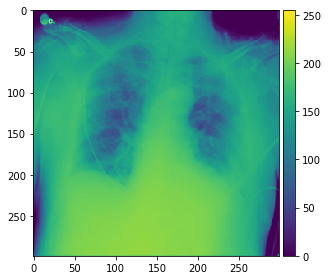

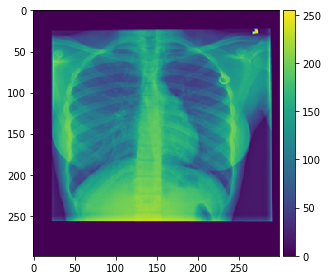

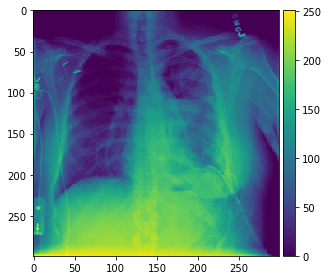

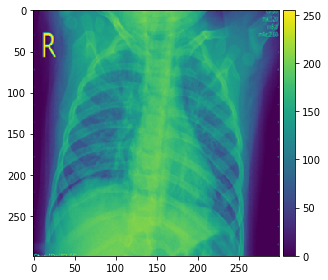

In [6]:
covid = imageReading(path_Covid)
normal = imageReading(path_Normal)
opacity = imageReading(path_Opacity)
pneumonia = imageReading(path_Pneumonia)

In [7]:
covid = torch.from_numpy(np.array(covid).reshape(-1,1,299,299))
normal = torch.from_numpy(np.array(normal).reshape(-1,1,299,299))
opacity = torch.from_numpy(np.array(opacity).reshape(-1,1,299,299))
pneumonia = torch.from_numpy(np.array(pneumonia).reshape(-1,1,299,299))

In [226]:
img_covidlist = []
for i in range(covid.shape[0]):
    img_covidlist.append((covid[i]/255.0,0.0))

img_normallist = []
for i in range(normal.shape[0]):
    img_normallist.append((normal[i]/255.0,1.0))
    
img_opacitylist = []
for i in range(opacity.shape[0]):
    img_opacitylist.append((opacity[i]/255.0,2.0))

img_pneumonialist = []
for i in range(pneumonia.shape[0]):
    img_pneumonialist.append((pneumonia[i]/255.0,3.0))    

In [227]:
# Covid
start = 0
training_limit_covid = int(len(img_covidlist)*0.70)
validation_limit_covid = training_limit_covid + int(len(img_covidlist)*0.20)
end_covid = len(img_covidlist)

# normal
training_limit_normal = int(len(img_normallist)*0.70)
validation_limit_normal = training_limit_normal +int(len(img_normallist)*0.20)
end_normal = len(img_normallist)

# Opacity
start = 0
training_limit_opacity = int(len(img_opacitylist)*0.70)
validation_limit_opacity = training_limit_opacity + int(len(img_opacitylist)*0.20)
end_opacity = len(img_opacitylist)

# Pneumonía
training_limit_pneumonia = int(len(img_pneumonialist)*0.70)
validation_limit_pneumonia = training_limit_pneumonia + int(len(img_pneumonialist)*0.20)
end_pneumonia = len(img_pneumonialist)

In [228]:
import random
random.shuffle(img_covidlist)
covid_train = img_covidlist[0:training_limit_covid]
covid_val = img_covidlist[training_limit_covid:validation_limit_covid]
covid_test = img_covidlist[training_limit_covid:end_covid]

random.shuffle(img_normallist)
normal_train = img_normallist[0:training_limit_normal]
normal_val = img_covidlist[training_limit_normal:validation_limit_normal]
normal_test = img_normallist[validation_limit_normal:end_normal]

random.shuffle(img_opacitylist)
opacity_train = img_opacitylist[0:training_limit_opacity]
opacity_val = img_covidlist[training_limit_opacity:validation_limit_opacity]
opacity_test = img_opacitylist[validation_limit_opacity:end_opacity]

random.shuffle(img_pneumonialist)
pneumonia_train = img_pneumonialist[0:training_limit_pneumonia]
pneumonia_val = img_covidlist[training_limit_pneumonia:validation_limit_pneumonia]
pneumonia_test = img_pneumonialist[validation_limit_pneumonia:end_pneumonia]

In [300]:
train_beta = covid_train + normal_train + opacity_train + pneumonia_train
val_beta = covid_val + normal_val + opacity_val + pneumonia_val
test_beta = covid_test + normal_test + opacity_test + pneumonia_test
random.shuffle(train_beta)
random.shuffle(val_beta)
random.shuffle(test_beta)

In [332]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=train_beta, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_beta, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_beta, batch_size=batch_size, shuffle=True)

In [355]:
num_classes = 4
learning_rate =  0.001
num_epochs = 20

class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        #input 299x299
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=0))
        #149 x 149
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #74x74
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        #36x36
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(128*9*9, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, num_classes)
            )
        
    def forward(self, x):
        out = self.layer1(x)
        #print('aviso1')
        out = self.layer2(out)
        #print('aviso2')
        out = self.layer3(out)
        out = self.layer4(out)
        #print('aviso3')
        out = out.reshape(out.size(0), -1)
        #print('aviso4')
        out = self.fc(out)
        return out 

In [356]:
model         = CNN(num_classes).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [357]:
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=10368, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=4, bias=True)
  )
)


In [358]:
def validation(model, device, val_loader, loss_function):
    # Settings
    model.eval()
    loss_total = 0

    # Test validation data
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            inputs = images.float().to(device)
            labels = labels.long().to(device)

            outputs = model(inputs).float()
            loss = loss_function(outputs, labels)
            loss_total += loss.item()

    return loss_total / len(val_loader)

In [359]:
def train(model, optimizer, loos_fn, num_epochs):
  loss_vals = []
  running_loss =0.0
  ultimo_loss = 100
  umbral_loss = 20
  times = 0
  # train the model
  total_step = len(train_loader)  # el train loader es el motor que se encarga de sacar las imagenes del train_set

  list_loss= []
  list_time = []
  j=0

  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images = images.float().to(device)
      labels = labels.long().to(device)
      # forward 
      output = model(images).float()
      loss   = loss_fn(output, labels)
      # change the params
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      list_loss.append(loss.item())
      list_time.append(j)
      j+=1
              
      if (i+1) % 50 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                      
  print('Finished Training Trainset')
  return list_loss

In [360]:
error_train = train(model,optimizer,loss_fn,20)

Finished Training Trainset


In [370]:
with torch.no_grad():
      y_true = []
      y_pred = []  
      correct = 0
      total = 0
      for images, labels in test_loader:
          images, labels = images.float().to(device), labels.float().to(device)
           
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
            
          total += labels.size(0)
          y_true.append(labels.cpu().data.numpy()) 
          y_pred.append(predicted.cpu().data.numpy())  
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 82.66666666666667 %


In [372]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.array(y_true[0:9]).flatten(), np.array(y_pred[0:9]).flatten())

array([[56,  7,  6,  4],
       [ 2, 19,  1,  0],
       [ 4,  0, 21,  0],
       [ 1,  1,  0, 22]], dtype=int64)

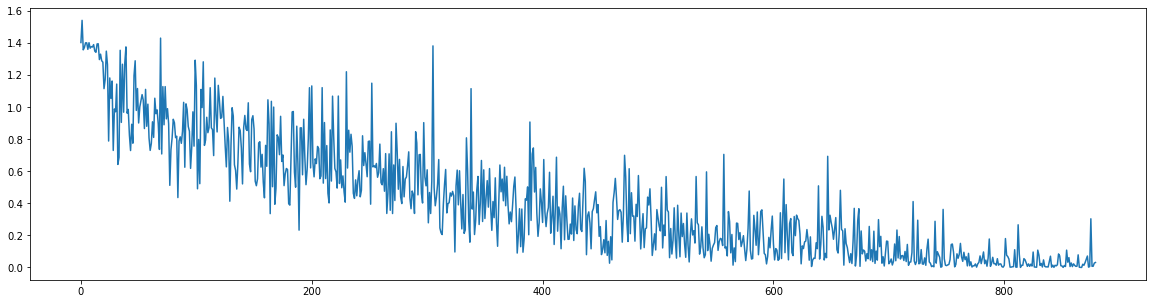

In [373]:
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
plt.plot(error_train)
plt.show()